In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
import os
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch import optim
from pytorch_lightning.core import LightningModule
from pytorch_lightning.metrics.functional import  accuracy 
from pytorch_lightning import loggers as pl_loggers
from torchvision import datasets, transforms
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
from pandas_profiling import ProfileReport
import seaborn as sns
import os
from pandas import DataFrame

C:\Users\mohamedr002\Anaconda3\envs\phd\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


# Data Description 

Associated tasks: classification
Number of examples: 1,098,207
Number of attributes: 6
Missing attribute values: None
Class distribution: {
	Walking -> 424,400 -> 38.6%,
	Jogging -> 342,177 -> 31.2%,
	Upstairs -> 122,869 -> 11.2%,
	Downstairs -> 100,427 -> 9.1%,
	Sitting -> 59,939 -> 5.5%,
	Standing -> 48,395 -> 4.4% }

raw.txt follows this format:
[user],[activity],[timestamp],[x-acceleration],[y-accel],[z-accel];

This line is a representative example:
33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;

Sampling rate: 
20Hz (1 sample every 50ms)

Fields:
*user
	nominal, 1..36

*activity
	nominal, {
		Walking
		Jogging
		Sitting
		Standing
		Upstairs
		Downstairs }

*timestamp
	numeric, generally the phone's uptime in nanoseconds
		(In future datasets this will be miliseconds
		since unix epoch.)

*x-acceleration
	numeric, floating-point values between -20 .. 20
		The acceleration in the x direction as measured
		by the android phone's accelerometer. 
		A value of 10 = 1g = 9.81 m/s^2, and
		0 = no acceleration.
		The acceleration recorded includes gravitational
		acceleration toward the center of the Earth, so
		that when the phone is at rest on a flat surface
		the vertical axis will register +-10. 

*y-accel
	numeric, see x-acceleration

*z-accel
        numeric, see x-acceleration

# Data Investigation 

In [3]:
# os.chdir("C:\\Users\\zhangw4\\Desktop\\Projects\\DG_Datasets")
save_dir = ".\\actitracker_ts"
data_dir = ".\\WISDM_ar_v1.1"


seq_length = 200
shifting_step = 20
num_variables = 3

# dataloading 
file = open(f'{data_dir}/WISDM_ar_v1.1_raw.txt', "r")
data = file.readlines()
# subjects = ['1603', '1775', '1793', '1238']
# subj2health = {'1603':'H', '1775':'H', '1793':'H', '1238':'I'}
subjects = ['20', '19', '31', '14']
subj2health = {'20':'H', '19':'H', '31':'H', '14':'H'}
data_subjects = [d.replace(';\n', '').split(',') for d in data if d[:2] in subjects]
df = pd.DataFrame(data_subjects, columns=('user', 'activity', 'time', 'x', 'y', 'z'))

In [30]:
# os.chdir("C:\\Users\\zhangw4\\Desktop\\Projects\\DG_Datasets")
save_dir = ".\\actitracker_ts"
data_dir = ".\\WISDM_ar_v1.1"


seq_length = 200
shifting_step = 20
num_variables = 3

# dataloading 
file = open(f'{data_dir}/WISDM_ar_v1.1_raw.txt', "r")
data = file.readlines()
sub = [str(i) for i in [0,1,2,3,4,7,8,11,15,29,31,32]]
data_subjects = [d.replace(';\n', '').split(',') for d in data if d[:2] in sub]
df = pd.DataFrame(data_subjects, columns=('user', 'activity', 'time', 'x', 'y', 'z'))




In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd

import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pdb

'''
WISDM 2 dataset
subjects with demographics and most number of samples
no injury: 1603, 1775, 1793
injury: 1238

activities 1.1: downstairs, jogging, sitting, standing, upstairs, walking
activities 2.0: lydingdown, sitting, stairs, standing, walking (in order of label)
'''

def sliding_window(time_series, width, step, order='F'):
    w = np.hstack([time_series[i:1 + i - width or None:step] for i in range(0, width)])
    result = w.reshape((int(len(w) / width), width), order='F')
    if order == 'F':
        return result
    else:
        return np.ascontiguousarray(result)

    
# convert categorical labels to numbers 
df['activity'] = df['activity'].astype('category')
df['labels'] = df['activity'].cat.codes

# drop irrelevant columns 
df_refined = df.drop(columns=['time', 'activity'])

# map one user per model
user_list = df_refined.user.unique().tolist()

# sliced data
# looping through user 
for u in user_list:
    data_um = df_refined[(df_refined.user==u)]
    data, labels = [], []
    # looping through data from each class
    for class_name, class_data in data_um.groupby('labels'):
        col_index = 0
        # slicing data to 200 with stride 40
        sliced_data = np.empty((math.ceil((class_data.shape[0]-seq_length+1)/shifting_step),seq_length, num_variables))
        for column in class_data[['x', 'y', 'z']]:
            column_data = class_data[column]
            sliced_data[:,:,col_index] = sliding_window(column_data.values, seq_length, shifting_step, 'T')
            col_index+=1
        # append data 
        data.append(sliced_data)
        # generate labels
        class_labels = np.empty(sliced_data.shape[0])
        class_labels.fill(class_name)
        labels.append(class_labels.astype(int))
    # data and labels for each user
    array_user_data = np.concatenate(data, axis=0 )
    array_user_labels = np.concatenate(labels, axis=0 )    
    # shuffle samples
    n_samples = array_user_data.shape[0]
    shuffle_idx = list(range(n_samples))
    random.seed(0)
    random.shuffle(shuffle_idx)
    array_user_data_shuffle = array_user_data[shuffle_idx]
    array_user_labels_shuffle = array_user_labels[shuffle_idx]
    # reshape to n_samples x num_variables x seq_length
    array_user_data_shuffle = array_user_data_shuffle.reshape((n_samples, num_variables, seq_length))
    # save
    tensor_user_data_shuffle = torch.tensor(array_user_data_shuffle).to(torch.float)
    tensor_user_labels_shuffle = torch.tensor(array_user_labels_shuffle).to(torch.long)
    combined_data = {'samples':tensor_user_data_shuffle, 
                     'labels':tensor_user_labels_shuffle}
    savefile = ''.join((subj2health[u], u))+'.pt'
    torch.save(combined_data, os.path.join(save_dir, savefile))

In [13]:
# Reading phones accelemeter datasets 
Wisdom_data = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt',delimiter="\s+|,|;", header=None, names = column_names, engine='python')
Wisdom_data.head()

ParserError: Expected 7 fields in line 134639, saw 13. Error could possibly be due to quotes being ignored when a multi-char delimiter is used.

## Dropping irrelevant columns and removing nulls 

In [4]:
# dropping nulls 
HHAR_phones_refined = HHAR_phones.dropna()
# dropping irrelevant columns 
HHAR_phones_refined = HHAR_phones_refined.drop(columns=['Index', 'Arrival_Time', 'Creation_Time'])

## Analyze user-based data 

number of samples per each user


i    1342007
b    1320280
e    1310856
g    1278593
d    1223857
h    1223093
a    1218871
c    1188186
f    1173532
Name: User, dtype: int64

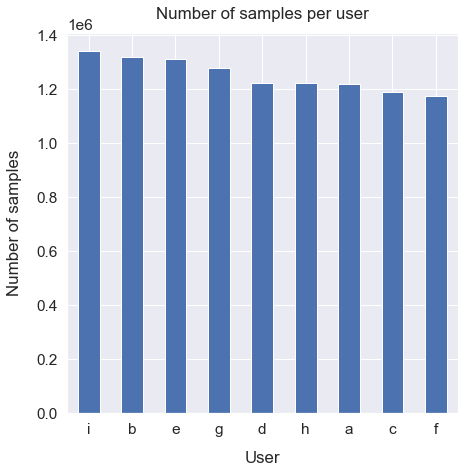

In [20]:
sns.set(font_scale=1.4)
HHAR_phones_refined['User'].value_counts().plot(kind='bar', figsize=(7, 7), rot=0)
plt.xlabel("User", labelpad=14)
plt.ylabel("Number of samples", labelpad=14)
plt.title("Number of samples per user", y=1.02);
print('number of samples per each user')
HHAR_phones_refined['User'].value_counts()

number of samples per each user


i    1342007
b    1320280
e    1310856
g    1278593
d    1223857
h    1223093
a    1218871
c    1188186
f    1173532
Name: User, dtype: int64

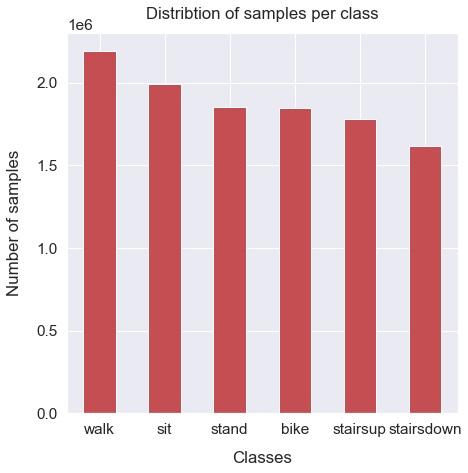

In [22]:
sns.set(font_scale=1.4)
HHAR_phones_refined['gt'].value_counts().plot(kind='bar', color= 'r', figsize=(7, 7), rot=0)
plt.xlabel("Classes", labelpad=14)
plt.ylabel("Number of samples", labelpad=14)
plt.title("Distribtion of samples per class", y=1.02);
print('number of samples per each user')
HHAR_phones_refined['User'].value_counts()

In [ ]:
# Plotting in subplopts the number of samples per each user per class 

## Class Distriubtion per each user  

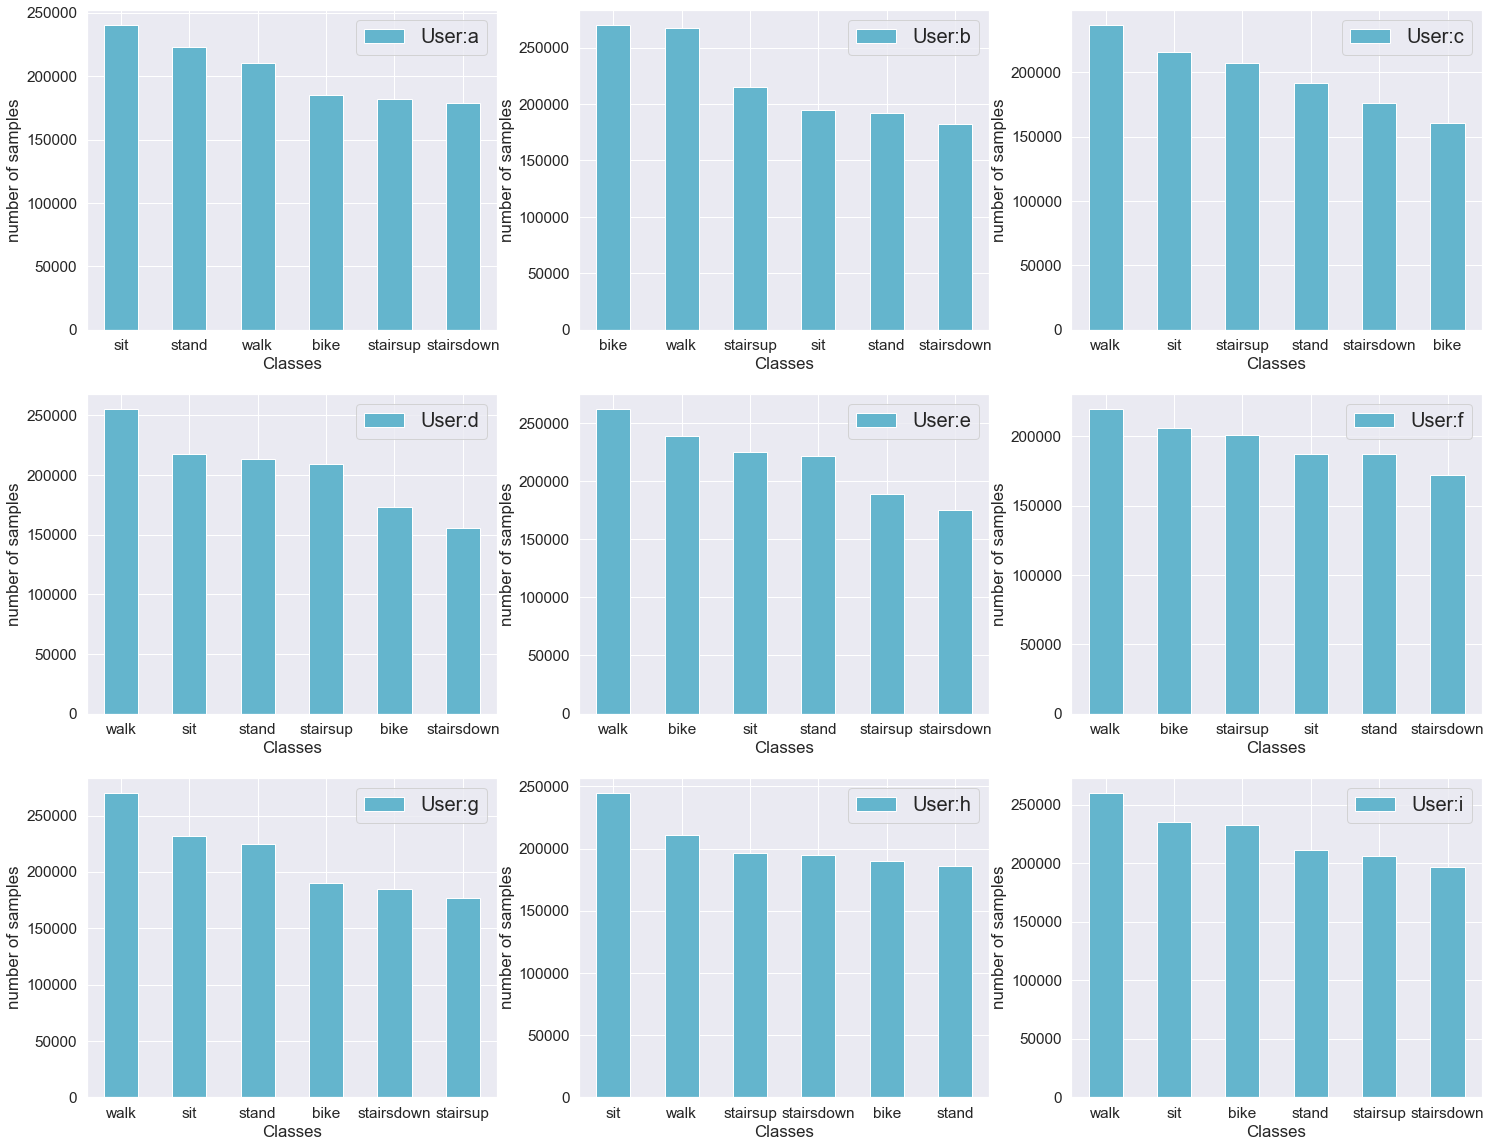

In [42]:
fig=plt.figure(figsize=(25,20))
plt.rcParams.update({'font.size': 10})
plt.title('Sensor_v1')

# markers=[',', '+', 'o', '.']
j=1
for i in HHAR_phones_refined.User.unique():
    plt.subplot(3,3,j)
    HHAR_phones_refined[HHAR_phones_refined.User==i]['gt'].value_counts().plot(kind='bar', label=f"User:{i}", color='c', rot=0)
    plt.xlabel('Classes')
    plt.ylabel('number of samples')
#     plt.plot(classes)
    plt.legend(prop={'size': 20})
    j+=1
plt.show()

In [14]:
ProfileReport(HHAR_phones_refined)